In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import xgboost as xgb
from torchvision import models
from torch import nn
from torch import optim

In [2]:
nan_val = -32768.0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train_chips = '/home/oqbrady/data/data/chips/train/'
val_chips = '/home/oqbrady/data/data/chips/validation/'
train_files = os.listdir('/home/oqbrady/data/data/chips/train/')
val_scenes = os.listdir(val_chips)
train_scences = os.listdir(train_chips)

In [4]:
inference_scenes = pd.read_csv('inference_scenes.csv')
inference = inference_scenes['0'].to_list()

In [5]:
pos_image_path = '/home/oqbrady/data/data/sub_boxes/positives_v3/'
neg_image_path = '/home/oqbrady/data/data/sub_boxes/negatives/'

In [6]:
labels_train = pd.read_csv("labels_v4_train.csv")
# labels_val = pd.read_csv("labels_v3_val.csv")

In [7]:
names = ['bay_mean', 'vh_mean', 'vh_max', 'vv_max', 'vh_min', 'vv_min', 'land', 'NaN', 'label', 'scene', 'chip', 'num']
neg_samples = pd.read_csv("negative_chip_vals.csv", names=names)

In [8]:
neg_samples = neg_samples.drop(np.nan)

In [9]:
neg_samples.shape

(1937374, 12)

In [10]:
# bst = xgb.Booster()  # init model
# bst.load_model('gbt_v1.model')  # load data
# test = neg_samples.drop(labels=['label', 'scene', 'chip', 'num'], axis=1)
# dtest = xgb.DMatrix(test)
# ypred = bst.predict(dtest)
# predictions = ypred > 0.5
# neg_samples['preds'] = predictions
# pos_neg_samples = neg_samples[neg_samples['preds'] == 1]

In [11]:
pos_neg_samples = pd.read_csv("positive_negative_samples.csv")

In [12]:
df_gbt = pd.read_csv("train_GBT.csv", names=names[:-3])

In [13]:
df_means = df_gbt.copy()

In [14]:
df_gbt

,bay_mean,vh_mean,vh_max,vv_max,vh_min,vv_min,land,NaN,label
0,-99.964500,-30.477900,-26.203125,-13.328125,-37.12500,-30.203125,0.0,0.0,0.0
1,-3594.778809,-28.181025,-24.625000,-15.484375,-34.87500,-32.562500,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.0,0.0,0.0
3,-39.001675,-28.543694,-23.734375,-17.656250,-37.31250,-32.468750,0.0,0.0,0.0
4,-46.351612,-29.431162,-25.296875,-15.976562,-39.18750,-29.562500,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1807139,-68.119278,-31.918276,-25.437500,-12.796875,-39.28125,-22.750000,0.0,0.0,0.0
1807140,-117.068878,-28.421625,-24.593750,-19.500000,-35.87500,-35.781250,0.0,0.0,0.0
1807141,-4764.534180,-32.727139,-27.000000,-21.421875,-38.81250,-35.125000,0.0,0.0,0.0
1807142,-125.340927,-30.516380,-25.765625,-13.593750,-37.43750,-27.921875,0.0,0.0,0.0


In [15]:
df_means[(df_means['NaN'] == 0)]['bay_mean'].std()

1674.5504056349082

In [16]:
df_means[(df_means['NaN'] == 0)]['bay_mean'].std()

1674.5504056349082

In [17]:
min_vh = df_means[df_means['vh_min'] != nan_val]['vh_min'].min()
min_vv = df_means[df_means['vv_min'] != nan_val]['vv_min'].min()
min_bay = df_means[(df_means['bay_mean'] != nan_val) & (df_means['NaN'] == 0)]['bay_mean'].min()

In [18]:
mean_vh = df_means[df_means['NaN'] != 1]['vh_mean'].mean()
mean_vv = -15 #df_means[df_means['NaN'] != 1]['vv_mean'].mean()
mean_bay = df_means[df_means['NaN'] != 1]['bay_mean'].mean()

In [19]:
std_vh = 7.4
std_vv = 5.15
std_bay = 1600

In [20]:
image_paths = []
labels = []

In [21]:
# base = neg_image_path
# for i in range(pos_neg_samples.shape[0]):
#     row = pos_neg_samples.iloc[i]
#     fl = base + row['scene'] + '_' + str(row['chip']) + '_' + str(row['num'])
#     image_paths.append(fl)
#     labels.append(0)

In [22]:
base = pos_image_path
for i in range(labels_train.shape[0]):
    row = labels_train.iloc[i]
    if pd.isna(row['lengths']):
        continue
    fl = base + row['scene'] + '_' + str(row['chip']) + '_' + str(row['num'])
    image_paths.append(fl)
    labels.append(row['lengths'])

In [23]:
# base = '/home/oqbrady/data/data/sub_boxes/inference/'
# images = [base + x for x in os.listdir(base)]
# image_paths.extend(images)
# labels.extend([0] * len(images))

In [24]:
len(image_paths)

34945

In [25]:
len(labels)

34945

In [26]:
class SARImagery(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, image_paths, labels, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.images = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.images[idx]
        num = img_name.split("_")[-1]
        vh = np.load(img_name + '/' + num + '_vh.npy')
        vv = np.load(img_name + '/' + num + '_vv.npy')
        bay = np.load(img_name + '/' + num + '_bay.npy')
        image = np.array((vv, vh, bay))
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        image = torch.from_numpy(image)
        if torch.isnan(image).any():
            image= torch.zeros((3, 50, 50))
        return (image.to(device), torch.tensor(label).to(device))

In [27]:
class drop_nans(object):
    def __call__(self, image):
        image[0, :, :][image[0, :, :] == -32768.] = min_vh - 10
        image[1, :, :][image[1, :, :] == -32768.] = min_vv - 10
        image[2, :, :][image[2, :, :] == -32768.] = min_bay - 100
        return image

class norm(object):
    def __call__(self, image):
        image[0, :, :] = (image[0, :, :] - mean_vh) / std_vh
        image[1, :, :] = (image[1, :, :] - mean_vv) / std_vv
        image[2, :, :] = (image[2, :, :] - mean_bay) / std_bay
        return image

In [28]:
transform = transforms.Compose(
    [drop_nans(),
    norm()])

In [29]:
dataset = SARImagery(image_paths, labels, transform=transform)

In [30]:
train_len = int(len(dataset) * 0.85)
val_len = len(dataset) - train_len

In [31]:
print(train_len, val_len)

29703 5242


In [32]:
train_data, val_data = torch.utils.data.random_split(dataset, lengths=[train_len,val_len])

In [33]:
labels_np = np.array(labels)

In [34]:
# class_counts = np.unique(labels_np, return_counts=True)[1]

In [35]:
# class_percent = class_counts / labels_np.shape[0]

In [36]:
# weights = 1 / class_percent

In [37]:
# class_percent

In [38]:
net = models.resnet18(pretrained=True)
net.fc = nn.Linear(in_features=512, out_features=1, bias=True)
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Dataset Prep

In [39]:
batch_size = 8
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True)

valloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                         shuffle=True)

In [40]:
print(len(train_data), len(val_data))

29703 5242


In [41]:
# w = torch.tensor(weights).to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [42]:
best_model = ""
min_val = 1

In [43]:
train_l = []
val_l = []

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(126.5478, device='cuda:0', dtype=torch.float64)


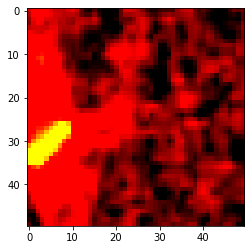

In [44]:
print(dataset[5][1])
plt.imshow(dataset[5][0].detach().cpu().numpy().transpose(1, 2, 0), cmap='gray')

In [45]:
def length_score(preds, real):
    score = 0
    for x, y in zip(preds, real):
        score += np.abs(x - y) / y
    score /= len(preds)
    score = min(score, 1)
    return 1 - score

In [48]:
np.abs(-5)

5

In [49]:
base = 0
for epoch in range(2, 100):  # loop over the dataset multiple times
    net.train()
    running_loss = 0.0
    run_tot_loss = 0.0
    j = 0
    for i, data in tqdm(enumerate(trainloader, 0)):
#         get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        outputs = net(inputs)
#         print(labels, outputs)
        optimizer.zero_grad()
#         print(outputs)
#         print(labels)
#         print(outputs.shape, labels.shape)
        loss = criterion(outputs, labels.reshape(-1, 1))
        loss.backward()
        optimizer.step()

        # print statistics
        run_tot_loss += loss.item()
        running_loss += loss.item()
        if i % 1000 == 999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch, i + 1, running_loss / 1000))
            running_loss = 0.0
        j += 1
    train_l.append(run_tot_loss / j)
    running_val_loss = 0
    correct = 0
    total = 0
    torch.save(net.state_dict(), 'saved_models/resnet_length_v2_' + str(epoch + base) + '.pth')
    k = 0
    net.eval()
    val_preds = []
    val_labels = []
    for j, data  in enumerate(valloader):
        k+=1
        images, labels = data
        with torch.no_grad():
            outputs = net(images)
            val_preds.append(outputs.detach().cpu().numpy())
            val_labels.append(labels.detach().cpu().numpy())
#             preds = torch.argmax(nn.functional.softmax(outputs, dim=1), dim=1)
#             correct += (preds == labels).sum()
#             total += labels.shape[0]
            loss = criterion(outputs, labels.reshape(-1, 1))
            running_val_loss += loss.item()
    print("val_loss", running_val_loss / k)
    val_l.append(running_val_loss / k)
    val_acc = length_score(np.concatenate(val_preds), np.concatenate(val_labels))
    print(np.concatenate(val_preds)[:20])
    print(np.concatenate(val_labels)[:20])
    print("Val accuracy", val_acc)
    val_loss = running_val_loss / k
    if val_loss < min_val:
        min_val = val_loss
        best_model = net
        best_epoch = epoch
print('Finished Training')

1000it [08:07,  1.92it/s]

[2,  1000] loss: 17.885


2000it [16:14,  2.22it/s]

[2,  2000] loss: 17.597


3000it [24:24,  1.46it/s]

[2,  3000] loss: 17.711


3713it [30:15,  2.05it/s]


val_loss 17.69442293811135
[[ 22.234627]
 [178.13332 ]
 [109.44536 ]
 [157.45636 ]
 [ 47.438354]
 [128.42447 ]
 [ 20.679247]
 [130.3209  ]
 [ 22.457458]
 [ 22.997896]
 [142.6708  ]
 [ 20.995546]
 [100.32826 ]
 [105.638054]
 [126.68526 ]
 [128.84973 ]
 [147.17998 ]
 [ 76.390175]
 [144.5562  ]
 [155.96924 ]]
[ 21.6        204.31361679  74.28364277 145.88451567  54.37213298
 113.9500685   21.8        110.05632291  22.8         23.61
 169.27872992  23.61       118.62458     14.2        106.60867394
 130.05945875 145.31171308  73.640187   193.45080668 192.39415925]
Val accuracy [0.7105672]


1000it [07:53,  2.22it/s]

[3,  1000] loss: 16.893


2000it [14:54,  2.15it/s]

[3,  2000] loss: 16.764


3000it [21:48,  2.35it/s]

[3,  3000] loss: 17.276


3713it [26:30,  2.33it/s]


val_loss 19.746988218731996
[[206.07088 ]
 [ 30.72765 ]
 [135.04977 ]
 [136.29317 ]
 [ 28.133951]
 [207.87433 ]
 [128.99683 ]
 [ 24.526657]
 [133.13623 ]
 [ 86.232315]
 [ 32.644756]
 [ 22.055218]
 [148.8879  ]
 [ 29.319822]
 [151.47772 ]
 [114.64991 ]
 [ 26.859976]
 [140.78854 ]
 [ 44.02032 ]
 [ 46.125874]]
[242.77529032  17.5        166.60151918 223.56659579  20.5
 242.97256536 132.8597981   16.435      143.31302693 108.85985852
  28.5         17.5        181.16028908  31.20000038 152.95397081
 128.91922763  25.70000038 239.81214491  45.40728906  23.94487844]
Val accuracy [0.69944274]


1000it [05:16,  3.00it/s]

[4,  1000] loss: 16.057


2000it [10:29,  2.99it/s]

[4,  2000] loss: 16.635


3000it [16:05,  2.62it/s]

[4,  3000] loss: 16.207


3713it [20:26,  3.03it/s]


val_loss 18.35115848699721
[[ 82.35717 ]
 [ 20.921898]
 [ 53.22463 ]
 [144.8376  ]
 [ 69.20016 ]
 [164.75897 ]
 [ 42.13165 ]
 [ 25.236555]
 [148.62186 ]
 [183.58504 ]
 [101.37397 ]
 [ 23.37674 ]
 [ 42.427383]
 [ 47.97301 ]
 [ 23.999043]
 [ 33.476974]
 [101.97819 ]
 [ 20.185488]
 [147.78477 ]
 [ 18.13963 ]]
[ 84.26701721  21.95        57.05192941 180.59422238  74.22575763
  67.48860899  45.13859945  31.5        160.01250623 236.17292954
 138.99104619  28.          37.3480466   29.96326328  24.2
  53.73428802  88.93353493  11.99       179.39454827  26.15      ]
Val accuracy [0.73960924]


1000it [05:53,  2.83it/s]

[5,  1000] loss: 15.833


2000it [11:46,  2.83it/s]

[5,  2000] loss: 15.232


3000it [17:40,  2.81it/s]

[5,  3000] loss: 15.678


3713it [21:53,  2.83it/s]


val_loss 19.636048839586536
[[121.59381 ]
 [ 19.92857 ]
 [121.54332 ]
 [128.54529 ]
 [146.20865 ]
 [ 43.603214]
 [ 76.3224  ]
 [ 17.563055]
 [ 24.84465 ]
 [ 31.871162]
 [152.57785 ]
 [ 83.01714 ]
 [126.36209 ]
 [ 27.387465]
 [116.25676 ]
 [ 16.342886]
 [ 54.980824]
 [123.41302 ]
 [ 22.943956]
 [100.57463 ]]
[ 47.74835653  24.2        146.83140563 173.82352266 129.19513671
  40.88119308  77.19447815  18.45000038  24.95        77.84068101
 234.68756861  75.43049766 145.14684241  28.5        226.11649458
  26.89        68.3526223  180.20285178  22.          58.11155977]
Val accuracy [0.7259834]


1000it [06:10,  2.81it/s]

[6,  1000] loss: 15.056


2000it [12:04,  2.79it/s]

[6,  2000] loss: 15.131


3000it [18:00,  2.80it/s]

[6,  3000] loss: 15.163


3713it [22:13,  2.78it/s]


val_loss 18.94766433646039
[[125.57698 ]
 [ 83.31307 ]
 [ 27.65698 ]
 [ 19.846212]
 [ 92.45699 ]
 [ 74.11092 ]
 [137.83784 ]
 [ 23.494682]
 [ 64.39408 ]
 [ 26.394876]
 [ 24.650984]
 [ 26.136198]
 [ 22.006641]
 [ 27.823822]
 [ 26.888247]
 [ 19.186102]
 [126.65559 ]
 [ 33.51129 ]
 [135.57149 ]
 [180.09052 ]]
[145.31171308 108.22419834  37.          15.03        26.0391199
 116.48421571 187.93879411  28.          60.          18.87818816
  21.76        23.39        30.5         31.5         20.96
  14.95       113.35748771  44.57696289 182.74670255 178.80934627]
Val accuracy [0.7383747]


1000it [05:53,  2.84it/s]

[7,  1000] loss: 14.459


2000it [12:02,  2.84it/s]

[7,  2000] loss: 14.454


3000it [17:57,  2.83it/s]

[7,  3000] loss: 14.209


3713it [22:09,  2.79it/s]


val_loss 17.629970812216037
[[ 17.88893 ]
 [ 39.632633]
 [ 20.951746]
 [ 35.31679 ]
 [ 43.12141 ]
 [ 96.09714 ]
 [147.10268 ]
 [132.54312 ]
 [ 75.82101 ]
 [ 50.019657]
 [174.38805 ]
 [ 29.273129]
 [ 90.32491 ]
 [154.10727 ]
 [ 20.101002]
 [ 21.038343]
 [110.718765]
 [158.43687 ]
 [ 27.429026]
 [ 91.9768  ]]
[ 23.38004965  46.04910657  20.77848551  63.85694353  46.74702824
  86.79877214 154.9591723  107.62810667  51.82420842  39.28640076
 181.16723869  29.95       113.25167981 151.43252755  21.52328293
  26.         130.18087794 170.99058234  19.         101.13287313]
Val accuracy [0.7320374]


1000it [05:53,  2.87it/s]

[8,  1000] loss: 13.306


2000it [11:47,  2.85it/s]

[8,  2000] loss: 13.965


3000it [17:51,  2.64it/s]

[8,  3000] loss: 14.058


3713it [22:13,  2.79it/s]


val_loss 18.132390506747292
[[ 34.526157]
 [ 24.734629]
 [ 49.39863 ]
 [267.04962 ]
 [ 22.479696]
 [ 27.54869 ]
 [ 23.914043]
 [130.9756  ]
 [ 19.089966]
 [ 22.106894]
 [ 89.94673 ]
 [ 83.5669  ]
 [ 78.09196 ]
 [ 19.570797]
 [ 48.389275]
 [ 22.392307]
 [105.93038 ]
 [ 23.927513]
 [ 31.237085]
 [ 17.179272]]
[ 39.26734884  15.11        43.53374327 247.43831729  36.20000038
  59.96774922  22.8        153.21453171  24.2         15.18937355
 122.15456643 107.61251104 114.66330163  19.23538428  53.90634791
  16.99        98.83678003  22.255       46.98518064  15.09000008]
Val accuracy [0.74385524]


1000it [05:54,  2.81it/s]

[9,  1000] loss: 13.318


2000it [11:49,  2.80it/s]

[9,  2000] loss: 13.590


3000it [17:43,  2.82it/s]

[9,  3000] loss: 12.714


3713it [21:56,  2.82it/s]


val_loss 18.807918575478762
[[ 21.477161]
 [ 71.77879 ]
 [ 32.10594 ]
 [ 22.821394]
 [137.5814  ]
 [ 41.711197]
 [ 23.689817]
 [116.17727 ]
 [ 17.083635]
 [ 34.0511  ]
 [ 29.647509]
 [ 47.7597  ]
 [143.4881  ]
 [126.23734 ]
 [ 51.98971 ]
 [ 93.62267 ]
 [ 65.15761 ]
 [ 75.25157 ]
 [ 22.325363]
 [ 65.07166 ]]
[ 26.14       101.21916242  52.38491307  25.24046418 175.54692199
  42.9         18.         112.66207748  16.56        31.5
  29.75        73.22528259 152.22091554 201.33311352  42.61997516
 133.0978956   57.15853206 156.37311229  20.         103.84099587]
Val accuracy [0.7286185]


1000it [06:10,  2.82it/s]

[10,  1000] loss: 12.361


2000it [12:06,  2.80it/s]

[10,  2000] loss: 12.503


3000it [18:01,  2.81it/s]

[10,  3000] loss: 12.322


3713it [22:15,  2.78it/s]


val_loss 19.117670702498135
[[ 21.518147]
 [ 65.64769 ]
 [ 23.934692]
 [ 37.58101 ]
 [ 81.37559 ]
 [193.07036 ]
 [ 19.677576]
 [ 28.424746]
 [156.4738  ]
 [ 40.23497 ]
 [ 23.943186]
 [ 17.633318]
 [ 64.711945]
 [ 26.166264]
 [ 19.655886]
 [ 78.816025]
 [ 85.723015]
 [113.22101 ]
 [ 19.95799 ]
 [ 33.016346]]
[ 28.          91.14223621  22.5         37.81267325  82.9139263
 214.03187265  22.32        28.         229.67749859  27.19333351
  27.12666646  51.33291488  23.94816386  26.          17.9
  40.68176207 100.85998713 165.21845662  18.5         15.35      ]
Val accuracy [0.73891103]


1000it [08:57,  2.22it/s]

[11,  1000] loss: 11.569


2000it [16:37,  2.27it/s]

[11,  2000] loss: 12.113


3000it [24:01,  2.34it/s]

[11,  3000] loss: 11.946


3713it [28:59,  2.14it/s]


val_loss 17.579312501520647
[[ 21.131245]
 [ 38.79835 ]
 [137.10422 ]
 [ 21.661825]
 [ 70.92839 ]
 [ 40.853558]
 [ 32.69953 ]
 [ 34.419506]
 [ 29.036955]
 [193.26314 ]
 [ 17.536705]
 [ 29.28505 ]
 [ 21.929607]
 [ 74.339714]
 [ 37.841587]
 [ 46.47656 ]
 [126.52788 ]
 [108.70956 ]
 [ 22.289808]
 [148.79878 ]]
[ 23.705       32.38846821 172.88577071  44.22781226  77.49944205
  49.32095469  37.97968272  30.70000038  29.86707409 236.35535697
  18.7         22.          14.         106.1189699   40.96895779
  36.79064113 117.40768348 104.5920833   20.6        210.24403258]
Val accuracy [0.7510233]


1000it [05:09,  3.18it/s]

[12,  1000] loss: 11.295


2000it [10:55,  2.82it/s]

[12,  2000] loss: 11.333


3000it [16:59,  2.64it/s]

[12,  3000] loss: 11.114


3713it [21:30,  2.88it/s]


val_loss 20.166966499351872
[[ 36.532196]
 [ 78.344   ]
 [ 32.785152]
 [145.31543 ]
 [ 19.101196]
 [124.11051 ]
 [134.36435 ]
 [ 20.18771 ]
 [ 17.10345 ]
 [ 66.0747  ]
 [ 25.31496 ]
 [138.33847 ]
 [152.20325 ]
 [ 18.735336]
 [ 22.2709  ]
 [ 22.229628]
 [ 18.030449]
 [ 82.36683 ]
 [150.92474 ]
 [ 21.453255]]
[ 34.05        68.09372866  14.98       168.41245672  15.9
 145.14684241 173.59345708  18.45000038  23.38004965  66.40261767
  24.95       158.24671796 174.0678895   22.25        27.38
  24.9         27.5        104.11958342 146.75728596  27.575     ]
Val accuracy [0.7406048]


1000it [08:02,  2.47it/s]

[13,  1000] loss: 11.005


2000it [15:36,  1.94it/s]

[13,  2000] loss: 10.445


3000it [23:41,  2.10it/s]

[13,  3000] loss: 10.752


3713it [29:08,  2.12it/s]


val_loss 20.438938585359875
[[ 15.659618]
 [ 75.95537 ]
 [ 70.71766 ]
 [ 47.15585 ]
 [ 83.743256]
 [165.67159 ]
 [ 63.442314]
 [130.18697 ]
 [ 37.436886]
 [177.18297 ]
 [ 72.02923 ]
 [ 80.05292 ]
 [ 63.96992 ]
 [ 57.967995]
 [ 63.14064 ]
 [ 22.023472]
 [ 86.31233 ]
 [ 20.02917 ]
 [124.311646]
 [ 17.682642]]
[ 18.5         98.18700285  94.54108419  45.39788236 138.99104619
 137.62228367 106.30947628 169.239319    22.72463088  87.0236812
 106.03961934  90.88237948  71.06327542  65.32442847  67.2188656
  20.6         66.78282819  31.         127.06062493  13.93818256]
Val accuracy [0.728581]


1000it [05:30,  2.99it/s]

[14,  1000] loss: 10.132


2000it [11:07,  3.11it/s]

[14,  2000] loss: 10.233


3000it [17:01,  2.79it/s]

[14,  3000] loss: 10.009


3713it [21:13,  2.92it/s]


val_loss 18.939324485456073
[[171.2675  ]
 [ 83.24705 ]
 [118.684204]
 [ 85.44671 ]
 [ 21.218836]
 [ 93.79014 ]
 [ 31.494585]
 [ 30.090164]
 [ 51.984795]
 [ 26.660332]
 [ 53.234245]
 [123.3923  ]
 [100.58765 ]
 [ 92.48939 ]
 [ 91.9785  ]
 [ 30.875225]
 [118.29722 ]
 [ 54.495564]
 [ 19.761944]
 [192.52702 ]]
[218.93457844 128.3140243  130.6         91.74978713  23.955
  67.35373128  24.61908285  22.65        30.15        16.22
  61.23380728 131.41623869  96.04700398 122.5196342   93.98487851
  24.00666883 110.05499947  53.90634791  21.71499501 204.18039339]
Val accuracy [0.73780346]


1000it [05:36,  2.96it/s]

[15,  1000] loss: 9.625


2000it [11:50,  1.73it/s]

[15,  2000] loss: 9.860


3000it [20:57,  2.05it/s]

[15,  3000] loss: 9.940


3713it [27:20,  2.26it/s]


val_loss 18.549004876758993
[[ 69.93246 ]
 [ 30.79343 ]
 [ 14.014184]
 [ 25.542809]
 [ 80.12025 ]
 [ 19.624508]
 [ 36.66267 ]
 [ 25.439747]
 [ 22.046625]
 [112.5066  ]
 [155.71143 ]
 [272.57935 ]
 [ 21.260088]
 [ 38.506737]
 [109.412636]
 [ 83.84102 ]
 [ 27.406324]
 [ 22.25981 ]
 [141.79312 ]
 [ 25.424187]]
[ 83.73836994  31.85        23.          26.         113.51593315
  31.5         88.08118495  30.89999981 214.16473545 114.58453624
 219.         236.35535697  18.          22.43752889 121.99930832
 115.35812199  26.09605432  17.435      202.1541725   67.34365847]
Val accuracy [0.73428756]


1000it [07:34,  1.78it/s]

[16,  1000] loss: 9.354


2000it [14:39,  2.63it/s]

[16,  2000] loss: 9.353


3000it [21:24,  2.60it/s]

[16,  3000] loss: 9.458


3713it [26:02,  2.38it/s]


val_loss 19.21426324364616
[[ 20.00182 ]
 [ 31.526749]
 [ 21.710537]
 [ 21.246603]
 [ 39.73076 ]
 [140.28966 ]
 [171.53188 ]
 [ 99.401634]
 [132.88354 ]
 [ 28.990673]
 [ 21.399479]
 [ 65.455414]
 [ 24.830572]
 [170.34033 ]
 [ 98.241714]
 [ 51.5967  ]
 [143.47113 ]
 [ 75.506134]
 [103.35172 ]
 [109.47055 ]]
[ 32.8         17.89732887  28.15        18.5         85.89123685
 185.01062152 239.09818803 144.82290903 152.4265721   31.39999981
  24.27       148.34712665  35.5        191.94771822 129.41871789
  38.25984594 197.89062142  80.60879373 116.48224908 112.83835247]
Val accuracy [0.73695004]


1000it [05:31,  3.06it/s]

[17,  1000] loss: 9.087


2000it [11:36,  2.82it/s]

[17,  2000] loss: 8.944


3000it [17:44,  2.84it/s]

[17,  3000] loss: 9.211


3713it [22:10,  2.79it/s]


val_loss 19.127692296010693
[[148.30646 ]
 [ 30.17113 ]
 [152.28447 ]
 [ 22.635313]
 [ 70.885864]
 [ 28.31491 ]
 [113.325134]
 [ 21.232811]
 [ 29.692997]
 [ 88.7236  ]
 [ 73.324486]
 [ 83.571106]
 [ 26.346312]
 [111.82923 ]
 [190.79333 ]
 [ 53.61369 ]
 [ 14.074941]
 [122.73741 ]
 [ 17.398685]
 [ 56.1944  ]]
[133.52854723  38.3661107  145.96264267  23.97        66.28
  26.78968773 108.          20.86666679  49.24221163 116.48224908
  83.43281847  79.54477958  22.32       156.29790853 214.0669027
  34.12630401  19.5        112.83835247  26.9         87.6       ]
Val accuracy [0.7411434]


1000it [06:09,  2.47it/s]

[18,  1000] loss: 8.612


2000it [12:22,  2.77it/s]

[18,  2000] loss: 8.618


3000it [18:49,  2.80it/s]

[18,  3000] loss: 8.925


3713it [23:11,  2.67it/s]


val_loss 18.846340159453998
[[160.14647 ]
 [ 16.997683]
 [ 68.63271 ]
 [160.07211 ]
 [ 18.172838]
 [ 59.90848 ]
 [141.65346 ]
 [ 18.68885 ]
 [ 22.934416]
 [ 98.8647  ]
 [ 21.9681  ]
 [ 21.614946]
 [163.4422  ]
 [ 24.535107]
 [ 83.21895 ]
 [ 19.749027]
 [ 26.858454]
 [ 26.030598]
 [ 16.395277]
 [ 28.103277]]
[229.          19.5         69.09179998  81.8         34.79865111
  73.29697234 162.74515064  28.5         19.82        75.12243355
  20.575       14.99       164.43706288  16.6        105.94072579
  16.          30.15        24.94         7.1         27.89999981]
Val accuracy [0.7343017]


1000it [06:10,  2.22it/s]

[19,  1000] loss: 8.383


2000it [12:20,  2.83it/s]

[19,  2000] loss: 8.079


3000it [18:33,  2.23it/s]

[19,  3000] loss: 8.436


3713it [23:01,  2.69it/s]


val_loss 19.95328430649711
[[ 91.80061 ]
 [ 23.474573]
 [152.75371 ]
 [ 65.55961 ]
 [ 86.15009 ]
 [ 30.315865]
 [ 31.14377 ]
 [ 96.21069 ]
 [ 21.37832 ]
 [ 17.446484]
 [ 80.76502 ]
 [ 24.76535 ]
 [123.23921 ]
 [ 58.569714]
 [ 24.403744]
 [130.48999 ]
 [ 33.73007 ]
 [ 74.356606]
 [126.69503 ]
 [ 65.95543 ]]
[114.0841934   26.         175.38833435  86.6473694   90.9367314
  41.78917517  31.53427259  32.29112229  24.          16.30446403
  84.48986995  27.27380818  47.74835653  65.31586356  24.95
 122.75593936  37.26691986  80.60879373 163.69622016  65.        ]
Val accuracy [0.7295854]


1000it [06:12,  2.84it/s]

[20,  1000] loss: 7.885


2000it [12:21,  2.24it/s]

[20,  2000] loss: 8.193


3000it [18:32,  2.84it/s]

[20,  3000] loss: 8.017


3713it [22:54,  2.70it/s]


val_loss 18.538988385622094
[[ 19.64837 ]
 [ 87.807175]
 [ 61.18258 ]
 [103.606445]
 [ 17.92066 ]
 [ 18.863754]
 [ 28.357807]
 [ 48.44951 ]
 [ 21.155066]
 [ 65.65233 ]
 [128.36975 ]
 [ 84.23252 ]
 [ 39.527363]
 [ 23.794216]
 [117.438095]
 [ 14.524297]
 [ 15.811121]
 [ 21.918104]
 [ 19.823505]
 [ 25.742811]]
[ 28.10000019 114.66330163  97.10870651  99.91        19.94
  35.59999923  45.69198024  41.72097462  23.39        98.93990096
 159.47632173 107.37982255  63.05011444  26.         137.10281711
  17.35999965  15.3         27.5         18.          31.5       ]
Val accuracy [0.7287699]


1000it [06:15,  2.65it/s]

[21,  1000] loss: 7.755


2000it [12:36,  2.84it/s]

[21,  2000] loss: 7.554


3000it [18:46,  2.25it/s]

[21,  3000] loss: 7.927


3713it [23:11,  2.67it/s]


val_loss 19.561832089976566
[[ 77.90239 ]
 [166.49483 ]
 [ 18.737335]
 [ 27.02695 ]
 [ 22.44963 ]
 [ 15.356451]
 [150.14873 ]
 [194.43883 ]
 [112.0808  ]
 [ 71.44237 ]
 [144.33754 ]
 [154.41545 ]
 [121.347466]
 [108.10764 ]
 [ 47.06756 ]
 [137.07608 ]
 [ 26.58956 ]
 [ 70.70164 ]
 [ 23.048836]
 [162.22353 ]]
[ 85.15954099 204.39628742  24.5         25.98676442  22.5
  16.7        181.17389993 232.10515321 185.94830705  81.08647128
 135.82403588 187.25260706 138.34843582 162.28384034  91.04994989
 178.2235743   18.7         64.68857118  17.25       161.01075124]
Val accuracy [0.7347976]


1000it [06:07,  2.80it/s]

[22,  1000] loss: 7.153


2000it [12:20,  2.85it/s]

[22,  2000] loss: 7.412


3000it [18:49,  2.78it/s]

[22,  3000] loss: 7.655


3713it [23:10,  2.67it/s]


val_loss 18.221911476152698
[[ 44.322567 ]
 [111.34061  ]
 [ 15.5398035]
 [210.59665  ]
 [109.15887  ]
 [122.27085  ]
 [123.59589  ]
 [172.22398  ]
 [136.30907  ]
 [132.9298   ]
 [171.00824  ]
 [ 57.352802 ]
 [103.56399  ]
 [ 23.091084 ]
 [155.13606  ]
 [ 22.304087 ]
 [151.94136  ]
 [ 43.391464 ]
 [208.80576  ]
 [ 22.895357 ]]
[ 38.61720056 147.26005306  12.36553635 202.73821073 120.65758681
 143.6763876  152.19802519 204.03231889 225.91792321 127.88967572
 148.17556752  87.46193667 116.48224908  30.70000038 115.01728502
  18.51514411 182.48416186  45.39788236 218.27377721  26.9       ]
Val accuracy [0.7253574]


1000it [06:08,  2.74it/s]

[23,  1000] loss: 7.258


2000it [12:20,  2.82it/s]

[23,  2000] loss: 7.233


3000it [18:27,  2.85it/s]

[23,  3000] loss: 7.591


3713it [22:59,  2.69it/s]


val_loss 18.244869356838667
[[107.8033   ]
 [131.03847  ]
 [ 46.484768 ]
 [ 88.94314  ]
 [ 21.504429 ]
 [155.57103  ]
 [139.22556  ]
 [118.17522  ]
 [187.03104  ]
 [128.80843  ]
 [ 20.36915  ]
 [ 15.6521635]
 [ 56.302082 ]
 [ 72.60443  ]
 [ 61.63222  ]
 [112.56201  ]
 [112.726685 ]
 [ 28.870998 ]
 [126.36934  ]
 [ 19.577927 ]]
[ 89.06146928 162.3261561   36.79064113  76.87186231  23.94
 154.53190813 157.24346942 107.62810667 196.18841453 173.59345708
  17.5         14.9290237   75.10656704  56.97418488  59.82365294
 129.12632133  94.05237721  24.62       156.55964563  18.42      ]
Val accuracy [0.7304696]


1000it [06:08,  2.81it/s]

[24,  1000] loss: 7.111


2000it [12:20,  2.84it/s]

[24,  2000] loss: 7.000


3000it [18:29,  2.84it/s]

[24,  3000] loss: 7.327


3713it [22:56,  2.70it/s]


val_loss 18.240654187231527
[[ 83.70808 ]
 [ 18.012836]
 [ 20.579338]
 [100.414276]
 [143.30093 ]
 [ 21.496021]
 [ 21.53072 ]
 [ 81.01259 ]
 [ 17.72631 ]
 [106.878685]
 [144.8763  ]
 [ 38.498962]
 [131.33727 ]
 [145.90039 ]
 [ 25.807878]
 [ 79.13503 ]
 [ 77.51657 ]
 [ 38.580753]
 [ 91.78064 ]
 [ 41.874744]]
[ 92.86145328  14.7         22.07197832 135.64902117 139.9
  23.61        23.06       113.45294529  16.         153.01509302
 184.02979819  47.94980113 153.13980504 144.4220727   24.95
  47.69318269  41.35018298  47.38687667  88.06326754  30.        ]
Val accuracy [0.72126913]


1000it [06:06,  2.60it/s]

[25,  1000] loss: 6.851


2000it [12:10,  2.80it/s]

[25,  2000] loss: 6.773


3000it [18:04,  2.82it/s]

[25,  3000] loss: 6.911


3713it [22:17,  2.78it/s]


val_loss 18.006092391726447
[[ 15.906864]
 [159.56413 ]
 [ 22.265442]
 [ 30.991693]
 [ 44.201538]
 [ 74.343315]
 [190.18509 ]
 [ 70.63802 ]
 [ 21.416933]
 [161.99333 ]
 [169.75424 ]
 [145.6389  ]
 [ 98.304855]
 [ 22.008049]
 [ 44.688374]
 [ 15.61006 ]
 [ 23.110363]
 [ 85.72926 ]
 [171.98843 ]
 [ 25.78201 ]]
[ 21.98221151 184.53843152  26.95480625  49.24221163  56.2283703
  69.09179998 231.82687169  93.23661303  22.915      142.89494714
 204.03231889 106.99169877  98.62572135  29.75        56.2283703
  24.81        20.79       104.03401505 205.77360905  30.5       ]
Val accuracy [0.73073584]


1000it [05:54,  2.84it/s]

[26,  1000] loss: 6.747


2000it [11:49,  2.81it/s]

[26,  2000] loss: 6.551


3000it [18:01,  2.79it/s]

[26,  3000] loss: 6.848


3713it [22:14,  2.78it/s]


val_loss 18.853231611048304
[[138.25327 ]
 [ 25.400642]
 [ 18.094097]
 [ 37.982456]
 [127.38026 ]
 [ 25.766993]
 [ 29.542439]
 [ 37.16848 ]
 [ 21.687033]
 [ 19.831905]
 [ 25.800404]
 [ 15.622544]
 [ 72.77888 ]
 [ 87.13168 ]
 [ 90.100655]
 [ 20.529572]
 [138.35281 ]
 [116.866745]
 [ 23.529608]
 [ 72.62936 ]]
[171.16390855  32.5         23.42        63.05011444 123.01558238
  17.19        17.9         29.4060832   22.5         17.86499495
  31.5         25.82        80.9587133   89.47218146  90.97282204
  16.23       138.40243887 174.28175206  28.05        77.67846521]
Val accuracy [0.7263513]


1000it [05:54,  2.85it/s]

[27,  1000] loss: 6.542


2000it [11:48,  2.83it/s]

[27,  2000] loss: 6.529


3000it [17:41,  2.84it/s]

[27,  3000] loss: 6.780


3713it [21:59,  2.81it/s]


val_loss 18.662441046499623
[[ 22.94782 ]
 [ 20.779547]
 [130.38902 ]
 [ 24.105923]
 [ 77.13048 ]
 [ 21.262474]
 [ 22.586866]
 [ 22.999144]
 [130.7382  ]
 [ 85.10374 ]
 [ 32.10744 ]
 [ 26.846079]
 [ 89.75441 ]
 [ 18.962051]
 [187.04053 ]
 [ 23.637032]
 [145.7674  ]
 [ 26.669676]
 [ 24.434431]
 [ 26.608437]]
[ 23.5         25.76104577 139.9         23.705       97.09685311
  24.9         28.          14.225      114.12142147 109.75413559
  28.1         23.88       126.35367532  16.         207.68831926
  13.71004378 104.89712097  28.          57.35105506  50.51376578]
Val accuracy [0.7297882]


1000it [05:55,  2.80it/s]

[28,  1000] loss: 6.365


2000it [11:50,  2.80it/s]

[28,  2000] loss: 6.564


3000it [17:45,  2.80it/s]

[28,  3000] loss: 6.404


3713it [21:58,  2.82it/s]


val_loss 19.18428378497682
[[151.72406 ]
 [ 24.448654]
 [ 91.144394]
 [ 20.53835 ]
 [165.87724 ]
 [ 56.315956]
 [ 91.17612 ]
 [151.18263 ]
 [201.43777 ]
 [ 16.642677]
 [ 37.521805]
 [115.0311  ]
 [ 78.1935  ]
 [ 97.91711 ]
 [ 23.518044]
 [107.721245]
 [ 15.437519]
 [ 24.415764]
 [ 58.324696]
 [ 71.264305]]
[204.03231889  23.93       114.58453624  33.09       139.1038011
  66.11422595 114.58453624 201.89388398 216.33547271  13.57487645
  35.15       179.49919367 156.37311229 160.80251328  28.56666641
 120.77108679  23.          14.60000019  49.99        67.94054278]
Val accuracy [0.7400348]


1000it [06:01,  2.62it/s]

[29,  1000] loss: 6.145


2000it [12:04,  2.85it/s]

[29,  2000] loss: 6.325


3000it [17:58,  2.82it/s]

[29,  3000] loss: 6.433


3713it [22:11,  2.79it/s]


val_loss 18.720323715994997
[[ 24.837055]
 [ 18.283386]
 [ 25.810772]
 [ 85.38734 ]
 [ 66.883446]
 [158.91328 ]
 [ 35.981342]
 [ 59.0303  ]
 [ 73.03863 ]
 [ 26.296543]
 [ 20.36092 ]
 [154.73451 ]
 [ 68.96969 ]
 [130.16298 ]
 [116.07576 ]
 [132.75386 ]
 [ 53.72218 ]
 [226.22021 ]
 [ 29.001633]
 [126.900215]]
[ 17.33        15.3         23.09        65.1         61.86
 176.57778809  24.0527272   69.56083724  82.97270089  35.5
  20.6        141.05842103  81.15048211 151.69630667 126.51107301
 137.02055621  60.81222172 242.82820394  20.17       139.22347899]
Val accuracy [0.7234651]


1000it [05:54,  2.84it/s]

[30,  1000] loss: 5.989


2000it [11:48,  2.85it/s]

[30,  2000] loss: 6.166


3000it [17:59,  2.83it/s]

[30,  3000] loss: 6.233


3713it [22:12,  2.79it/s]


val_loss 19.771011270400955
[[114.58166 ]
 [ 29.729029]
 [ 58.414474]
 [ 15.617939]
 [ 33.79582 ]
 [ 45.917923]
 [ 42.888832]
 [152.13985 ]
 [ 25.216568]
 [110.6418  ]
 [ 68.23222 ]
 [ 26.76164 ]
 [ 77.04267 ]
 [155.1337  ]
 [ 47.97601 ]
 [ 14.9532  ]
 [ 21.77676 ]
 [ 31.929255]
 [142.72585 ]
 [130.99394 ]]
[134.2         32.          66.40261767  21.6         29.82529778
  34.64618611  27.49        69.7730387   18.5        121.99930832
  76.19696098  25.24046418  78.70184221 173.10910236  60.50148352
  17.42189111  29.          33.         183.00147875 111.5634194 ]
Val accuracy [0.7255638]


1000it [05:53,  2.85it/s]

[31,  1000] loss: 6.066


2000it [11:47,  2.83it/s]

[31,  2000] loss: 6.084


3000it [17:42,  2.83it/s]

[31,  3000] loss: 6.224


3713it [21:59,  2.81it/s]


val_loss 18.384344788586223
[[133.95514 ]
 [ 21.593452]
 [ 60.319763]
 [142.93744 ]
 [173.57382 ]
 [ 20.238632]
 [ 85.0316  ]
 [ 20.98409 ]
 [ 38.942314]
 [ 79.136665]
 [ 49.15927 ]
 [ 19.089687]
 [153.41583 ]
 [ 65.34495 ]
 [137.9162  ]
 [ 40.170773]
 [ 34.501755]
 [174.4662  ]
 [ 21.18477 ]
 [167.4108  ]]
[124.88538501  26.15        74.22575763 177.03251959 168.06789486
  18.72        85.29020755  20.5         26.          41.35018298
  61.23380728  17.89732887 218.21807568  86.6473694  168.22171559
  20.15        51.3        156.6556518   23.83054148 216.25696954]
Val accuracy [0.7269769]


1000it [05:54,  2.81it/s]

[32,  1000] loss: 5.802


2000it [11:49,  2.84it/s]

[32,  2000] loss: 5.855


3000it [17:43,  2.84it/s]

[32,  3000] loss: 6.042


3713it [21:56,  2.82it/s]


val_loss 19.271000542655223
[[139.04259 ]
 [ 85.93916 ]
 [129.25337 ]
 [ 22.663857]
 [ 50.70854 ]
 [ 27.007114]
 [ 44.50588 ]
 [ 82.99162 ]
 [ 22.333776]
 [ 21.173086]
 [ 59.22319 ]
 [ 21.726662]
 [ 77.319336]
 [123.788635]
 [ 16.99973 ]
 [ 59.376705]
 [ 29.351955]
 [ 61.547653]
 [ 50.193947]
 [120.674774]]
[162.74515064  89.47218146 160.72323579  17.9         45.13859945
  29.86666679  31.1392924  125.66458763  19.17        33.09
  87.30206716  24.925       85.27432208 120.03239308  13.1
  64.87461302  24.00666883  41.51329929  83.02170899 154.62255267]
Val accuracy [0.7258428]


1000it [05:59,  2.60it/s]

[33,  1000] loss: 5.623


2000it [12:03,  2.84it/s]

[33,  2000] loss: 5.868


3000it [17:57,  2.85it/s]

[33,  3000] loss: 5.905


3713it [22:09,  2.79it/s]


val_loss 18.82387387243713
[[169.3485  ]
 [ 19.142431]
 [139.97107 ]
 [ 95.71274 ]
 [ 27.88266 ]
 [ 40.320755]
 [ 32.60106 ]
 [ 22.698093]
 [ 18.922234]
 [156.90678 ]
 [ 21.065182]
 [ 30.012295]
 [ 25.893488]
 [ 26.694866]
 [ 81.2596  ]
 [111.11559 ]
 [ 80.190956]
 [ 24.885365]
 [152.00484 ]
 [158.32587 ]]
[192.87673126  18.54999962 179.49919367  77.66741988  23.92
  40.52674235  49.64683816  24.           9.69       165.20896646
  13.72        21.5         36.4763194   61.30725007 108.22419834
 105.71470166 101.0851229   13.13799767  81.8        325.09043382]
Val accuracy [0.7364985]


1000it [05:54,  2.82it/s]

[34,  1000] loss: 5.750


2000it [11:48,  2.82it/s]

[34,  2000] loss: 5.844


3000it [18:01,  2.83it/s]

[34,  3000] loss: 5.544


3713it [22:14,  2.78it/s]


val_loss 20.520095966938065
[[ 20.986162]
 [ 70.98337 ]
 [ 22.819078]
 [151.67278 ]
 [ 22.184109]
 [ 93.77388 ]
 [ 49.616486]
 [129.46576 ]
 [ 27.895155]
 [100.02288 ]
 [ 22.532053]
 [153.6734  ]
 [176.6377  ]
 [ 24.555752]
 [121.9775  ]
 [ 25.737461]
 [122.62199 ]
 [ 25.311583]
 [ 19.761616]
 [129.0057  ]]
[ 28.          81.55472727  40.9         96.05001013  28.
 106.53659604  82.29958816 171.42372756  45.40728906  77.66741988
  18.5        168.23360364 147.29120785  16.5        166.41558059
  62.99212035  48.24922211  22.74        19.         160.27129596]
Val accuracy [0.7302152]


1000it [05:54,  2.85it/s]

[35,  1000] loss: 5.487


2000it [11:48,  2.84it/s]

[35,  2000] loss: 5.483


3000it [17:41,  2.82it/s]

[35,  3000] loss: 5.769


3713it [21:59,  2.81it/s]


val_loss 19.355987008025007
[[ 69.33811 ]
 [128.84624 ]
 [ 16.59415 ]
 [ 80.11147 ]
 [ 18.604511]
 [ 96.05713 ]
 [197.34    ]
 [127.74735 ]
 [147.78609 ]
 [ 67.809006]
 [ 21.09032 ]
 [142.35509 ]
 [ 75.83345 ]
 [128.23796 ]
 [ 94.9909  ]
 [ 23.761488]
 [145.1478  ]
 [ 18.900732]
 [ 22.700552]
 [ 18.328915]]
[ 91.95475646 179.39454827  37.          91.83809891  16.12906202
  87.18979431  45.70610392 148.67145103 198.27224242  64.31500535
  33.5        156.33646242  88.44400761 109.96308337  90.29806092
  20.84       154.94264988  20.15        23.20136211  22.5       ]
Val accuracy [0.7331797]


1000it [05:54,  2.76it/s]

[36,  1000] loss: 5.388


2000it [11:50,  2.78it/s]

[36,  2000] loss: 5.606


3000it [17:45,  2.78it/s]

[36,  3000] loss: 5.432


3713it [21:57,  2.82it/s]


val_loss 18.5354077997731
[[ 90.520515]
 [110.93834 ]
 [ 32.053055]
 [ 30.874237]
 [131.60783 ]
 [ 22.189846]
 [135.24832 ]
 [ 33.292946]
 [ 38.81659 ]
 [ 30.137869]
 [ 33.577126]
 [ 89.30017 ]
 [117.376076]
 [101.84803 ]
 [ 77.737465]
 [ 35.461357]
 [ 25.710394]
 [ 19.993795]
 [ 42.07391 ]
 [ 46.93444 ]]
[126.18528825 153.5689085   23.63599762  15.2933846  135.83445178
  21.         176.04967413  38.27332777  25.99163079  52.02132999
  35.92683219  98.18700285 143.88938858  93.06841697  54.49993437
  40.305       29.61333361  22.5         61.10771136  63.82494611]
Val accuracy [0.734088]


1000it [06:00,  2.66it/s]

[37,  1000] loss: 5.556


2000it [12:04,  2.80it/s]

[37,  2000] loss: 5.587


3000it [17:58,  2.84it/s]

[37,  3000] loss: 5.357


3405it [20:20,  2.79it/s]


KeyboardInterrupt: 

In [98]:
os.listdir("/home/oqbrady/data/data/sub_boxes/")

['positives_v3',
 'inference',
 'negatives_v2',
 'positives_v2',
 'positives',
 'negatives']

In [209]:
preds_all = []
correct_all = []
correct = 0
total = 0
running_val_loss = 0
for j, data  in enumerate(valloader):
    images, labels = data
    with torch.no_grad():
        outputs = net(images)
        soft = nn.functional.softmax(outputs, dim=1)
#         print(soft)
#         soft[:, 1] = soft[:, 1] + 0.9
#         print(soft)
        preds = torch.argmax(soft, dim=1)
        preds_all.append(preds.detach().cpu().numpy())
        correct_all.append(labels.detach().cpu().numpy())
        correct += (preds == labels).sum()
        total += labels.shape[0]
        loss = criterion(outputs, labels)
        running_val_loss += loss.item()
print("test_loss", running_val_loss / j)
print("test accuracy", correct / total)

test_loss 0.4040759995670212
test accuracy tensor(0.8642, device='cuda:0')


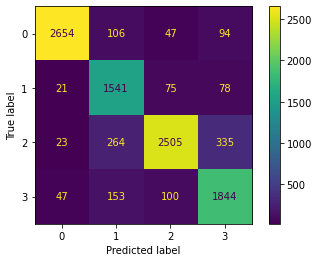

In [210]:
x = confusion_matrix(np.concatenate(correct_all), np.concatenate(preds_all))
ConfusionMatrixDisplay(x).plot()